Badanie polegało na uderzaniu maszyny z przemocowanymi do niej akcelerometrami różnymi narzędziami (m. in. stalowy klucz, gumowy młotek), a następnie przy wykorzystaniu SVM utworzenie modelu klasyfikującego te uderzenia.

In [1]:
import numpy as np
import pandas as pd
from sklearn import model_selection, svm
import os
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

Stałe klasyfikacyjne

In [2]:
klasyfikacja = {0: "klucz", 1: "młotek"}
kolory_klas = {0:'r', 1:'g'}

Funkcja do wczytywania i podziału danych na testowe i treningowe

In [3]:
def wczytaj_dane(procent_test,
                 foldery=['uderzenia/skalowane/bez_sortowania/uderzenia1', 'uderzenia/skalowane/bez_sortowania/uderzenia2'],
                ):
    
    '''
    Wczytuje dane i dzieli je na testowe i treningowe.
    Argumenty:
    - procent_test <float> - procent podziału na dane testowe z wszystkich danych
    - foldery < list(<str>) > - ścieżka do plików pomiarowych
    Zwraca:
    - Krotka w formacie X treningowe, X testowe, y treningowe, y testowe
    '''
    
    global klasyfikacja
    # słownik zapisujący przynależność danego pliku do klasy
    y_klasy = {}

    # wczytanie plików ze ścieżki i utworzenie z nich pojedynczego DataFrame
    list_dfs = []
    for k, dane in enumerate(foldery):
        df = []
        for i,plik in enumerate(os.listdir(dane)):
            df.append(pd.read_csv((os.path.join(dane, plik)), header=None, names=[plik]))
            y_klasy[plik] = k
        temp = pd.concat([d for d in df], axis=1)
        list_dfs.append(temp)

    full_df = np.abs(pd.concat([d for d in list_dfs], axis=1).dropna())

    # przygotowanie wejść i wyjść do treningu
    X = np.array([full_df[d] for d in full_df.columns])
    y = np.array([y_klasy[d] for d in full_df.columns])

    # podział na dane treningowe i testowe
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=procent_test)
    
    print("Wczytywanie danych")
    print(f'   Ilość danych {klasyfikacja[0]}:        {len(y_klasy) - np.sum([v for v in y_klasy.values()])}')
    print(f'   Ilość danych {klasyfikacja[1]}:       {np.sum([v for v in y_klasy.values()])}')
    print(f"   Ilość danych wczytanych:   {len(y_klasy)}")
    print(f"   Ilość danych treningowych: {len(y_train)}")
    print(f"   Ilość danych testowych:    {len(y_test)}")
    
    return X_train, X_test, y_train, y_test

Funkcja do treningu SVC, sprawdza każdą z dostępnych po kolei i wybiera tę która najlepiej wypadła w danych testowych

In [4]:
def trenuj_svm(data):
    '''
    Funkcja trenująca po kolei zadane w SVMdict modele i zwracający najlepszy wytrenowany z modeli.
    Argumenty:
    - data <tuple> <list> - dane w formacie X treningowe, X testowe, y treningowe, y testowe
    Zwraca:
    - wytrenowany model SVC o najlepszych osiągach w danych testowych (w przypadku gdy modele mają taki sam wynik sprawdza jeszcze
    wynik z danych treningowych)
    '''
    X_train, X_test, y_train, y_test = data[0], data[1], data[2], data[3]
    
    SVMdict = {
        0: svm.SVC(gamma='auto', kernel='linear'),
        1: svm.LinearSVC(),
        2: svm.NuSVC(gamma='auto'),
        3: svm.NuSVC(gamma='auto', kernel='linear'),
    }

    SVMdict_labels = {
        0: "SVC linear kernel",
        1: "LinearSVC",
        2: "NuSVC",
        3: "NuSVC linear kernel",
    }

    best_accuracy = 0
    best_test_acc = 0
    best_svc = None

    for svc in SVMdict:
        clf = SVMdict[svc]
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        if score > best_accuracy or score == best_accuracy and clf.score(X_train, y_train) > best_test_acc:
            best_accuracy = score
            best_test_acc = clf.score(X_train, y_train)
            best_svc = svc
        



    clf = SVMdict[best_svc]
    clf.fit(X_train, y_train)

    # wyświetlenie wyniku treningu
    print("Trening modelu")
    print(f'   Klasyfikator: {SVMdict_labels[best_svc]}')
    print(f'   Poprawność dla danych testowych:    {clf.score(X_test, y_test)*100:.2f}%')
    print(f'   Poprawność dla danych treningowych: {clf.score(X_train, y_train)*100:.2f}%')
    
    return clf

-----------------------------------------------------

Znajdowanie i klasyfikacja uderzeń na pełnych pomiarach

- Funkcja znajdująca uderzenia i ich szczyt, identyczna do tej wykorzystanej w preprocessingu

In [5]:
def find_hits(data, density=800, width=200, testing_width=50, threshold=6, skaluj=True):
    '''
    Funkcja znajdująca uderzenia w pomiarze.
    Szuka w oknach o szerokości 'testing_width' przekroczenia stosunku średniej wartości w danym oknie
    do wartości referencyjnej, gdy znajdzie szuka w okolicy największej wartości i uznaje to miejsce
    za środek uderzenia względem którego tworzy kolumnę w 'hits' która przedstawia dane uderzenie.
    Dodatkowo skaluje ona wartości tak żeby największa wartość była równa 1.
    Argumenty funkcji:
    - data <pandas.DataFrame()> - pełny pomiar w postaci pojedynczej kolumny
    - density <int> - możliwa gęstość uderzeń, po znalezieniu uderzenia w tej odległości poszukiwane będzie
    kolejne
    - width <int> - ilość próbek znalezionego uderzenia
    - testing_width <int> - szerokość badanego okna
    - threshold <int/float> - minimalny stosunek dla którego uderzenie zostanie uznane
    Funkcja zwraca:
    - hits <pandas.DataFrame()> - znalezione uderzenia, gdzie każda kolumna to osobne uderzenie a nazwa tej kolumny odpowiada
    środkowi uderzenia
    '''
    
    # DataFrame w którym będą znajdować się znalezione uderzenia
    hits = pd.DataFrame()
    
    # Wartość referencyjna do której porównywane będą badane okna pomiaru - średnia z całego pomiaru
    reference = np.mean(np.abs(data))
    
    # Szukanie przekroczenia stosunku średniej wartości bezwględnej w oknie do wartości referencyjnej
    i = 0
    while i < len(data) - width:
        if np.mean(np.abs(data[i:i+testing_width]))/reference > threshold:
            #peak = np.argmax(np.abs(data[i-density//2:i+density//2]))
            peak = np.abs(data[i-density//2:i+density//2]).idxmax()
            if skaluj:
                scale = 1/np.max(np.abs(data[i-density//2:i+density//2]))
                hits[peak] = scale * np.array(data)[peak-width//4:peak+3*width//4]
            else:
                hits[peak] = np.array(data)[peak-width//4:peak+3*width//4]

            i += density
        else:
            i += testing_width//2
      
    return hits

- Wczytanie próbki

In [6]:
def testuj_pomiar(width=200, directory='zmienne pochylenie/obc_uderzenia/2_ai0.csv', skaluj=True):
    df = pd.read_csv(directory, header=None)
    df = df.abs()
    hits = find_hits(df[0], width=width, skaluj=skaluj);

    fig = plt.figure(figsize=(12,6))
    axis = fig.add_subplot(111)
    axis.plot(df[0], color='b')

    for hit in hits.columns:
        x_plot = np.arange(hit-width//4, hit+3*width//4)
        y_plot = hits[hit]

        predykcja = clf.predict(np.array(y_plot).reshape(-1, width))[0]

        axis.plot(np.arange(hit-width//4,hit+3*width//4), df[0][hit-width//4:hit+3*width//4], color=kolory_klas[predykcja])
        axis.text(hit+len(df[0])//100, df[0][hit], klasyfikacja[predykcja], fontsize=12)
        
    return axis

---
Dane podzielone

- skalowane do 1 dla ai0

Wczytywanie danych
   Ilość danych klucz:        10
   Ilość danych młotek:       8
   Ilość danych wczytanych:   18
   Ilość danych treningowych: 16
   Ilość danych testowych:    2
Trening modelu
   Klasyfikator: SVC linear kernel
   Poprawność dla danych testowych:    100.00%
   Poprawność dla danych treningowych: 100.00%


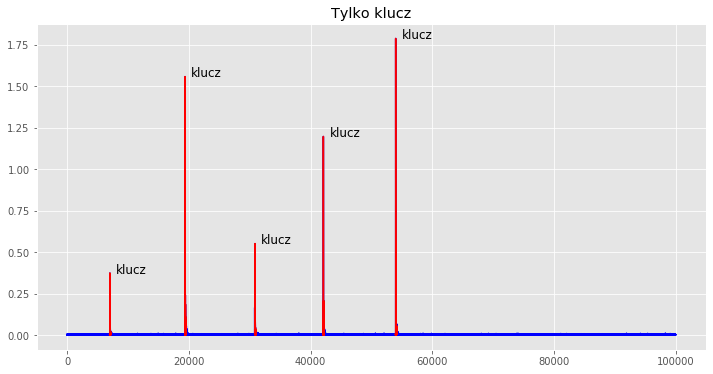

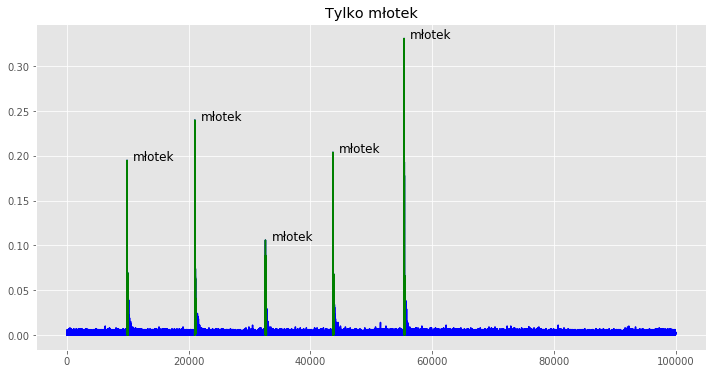

In [7]:
pomiary = ['uderzenia/skalowane/uderzenia1/ai0', 'uderzenia/skalowane/uderzenia2/ai0']
dane = wczytaj_dane(0.1, foldery=pomiary)
clf = trenuj_svm(dane)
ax1 = testuj_pomiar(directory = 'zmienne pochylenie/obc_uderzenia/2_ai0.csv', skaluj=True);
ax1.set_title("Tylko klucz");
ax2 = testuj_pomiar(directory = 'zmienne pochylenie/obc_uderzenia2/2_ai0.csv', skaluj=True);
ax2.set_title("Tylko młotek");

Pomiary te są wyłączone z danych treningowych i testowych - w pełni obiektywny test

- ai0 bez skalowania

Wczytywanie danych
   Ilość danych klucz:        10
   Ilość danych młotek:       8
   Ilość danych wczytanych:   18
   Ilość danych treningowych: 16
   Ilość danych testowych:    2
Trening modelu
   Klasyfikator: LinearSVC
   Poprawność dla danych testowych:    100.00%
   Poprawność dla danych treningowych: 100.00%


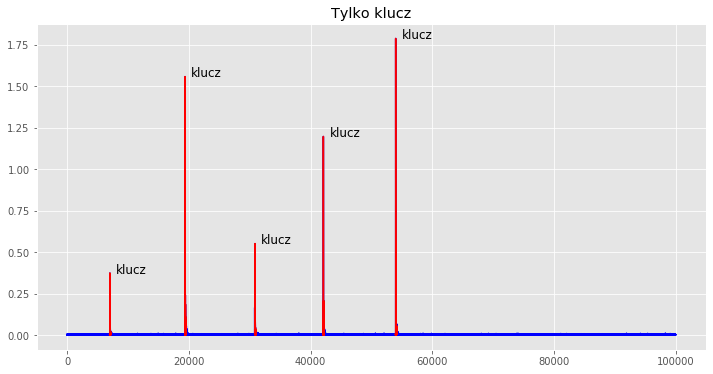

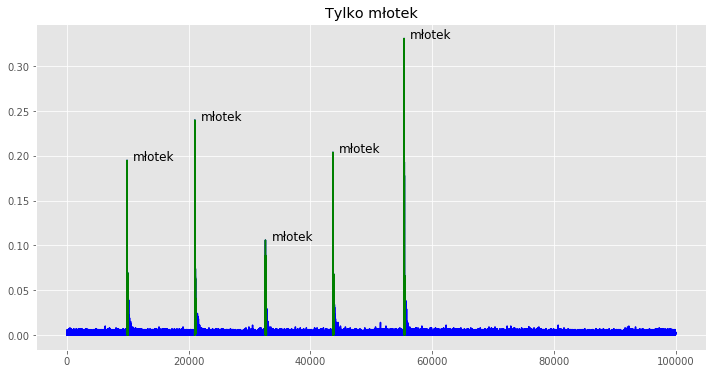

In [8]:
pomiary = ['uderzenia/uderzenia1/ai0', 'uderzenia/uderzenia2/ai0']
dane = wczytaj_dane(0.1, foldery=pomiary)
clf = trenuj_svm(dane)
ax1 = testuj_pomiar(directory = 'zmienne pochylenie/obc_uderzenia/2_ai0.csv', skaluj=True);
ax1.set_title("Tylko klucz");
ax2 = testuj_pomiar(directory = 'zmienne pochylenie/obc_uderzenia2/2_ai0.csv', skaluj=True);
ax2.set_title("Tylko młotek");

Dla tej liczby danych ciężko znaleźć definytywne różnice w klasyfikacji z i bez skalowania -- temat do dalszej eksploracji

Próbka dla innych czujników

- ai1

Wczytywanie danych
   Ilość danych klucz:        10
   Ilość danych młotek:       10
   Ilość danych wczytanych:   20
   Ilość danych treningowych: 16
   Ilość danych testowych:    4
Trening modelu
   Klasyfikator: NuSVC linear kernel
   Poprawność dla danych testowych:    100.00%
   Poprawność dla danych treningowych: 93.75%


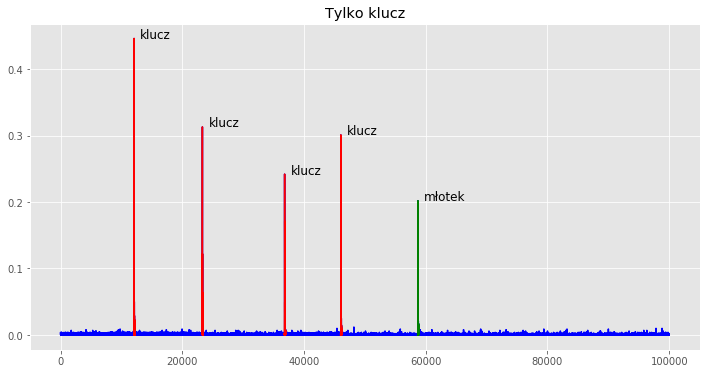

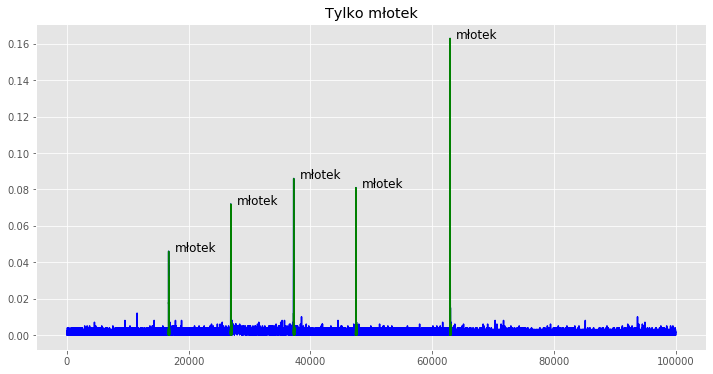

In [9]:
pomiary = ['uderzenia/uderzenia1/ai1', 'uderzenia/uderzenia2/ai1']
dane = wczytaj_dane(0.2, foldery=pomiary)
clf = trenuj_svm(dane)
ax1 = testuj_pomiar(directory = 'zmienne pochylenie/obc_uderzenia/3_ai1.csv', skaluj=False);
ax1.set_title("Tylko klucz");
ax2 = testuj_pomiar(directory = 'zmienne pochylenie/obc_uderzenia2/3_ai1.csv', skaluj=False);
ax2.set_title("Tylko młotek");

Dla ai2 za mała liczba próbek (5 kluczem i 3 młotkiem)

---
Połączenie pomiarów z i bez obciążenia

Wczytywanie danych
   Ilość danych klucz:        25
   Ilość danych młotek:       21
   Ilość danych wczytanych:   46
   Ilość danych treningowych: 36
   Ilość danych testowych:    10
Trening modelu
   Klasyfikator: LinearSVC
   Poprawność dla danych testowych:    90.00%
   Poprawność dla danych treningowych: 97.22%


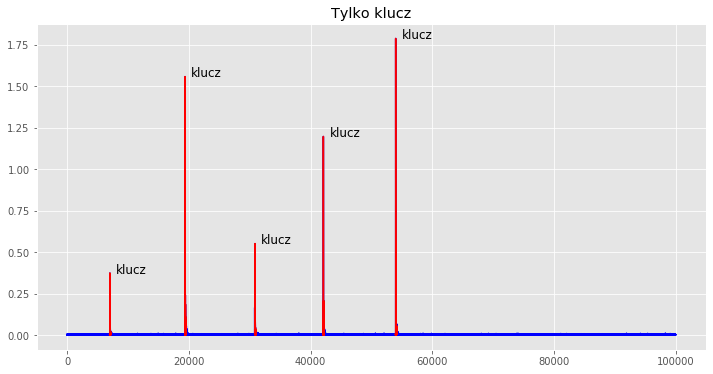

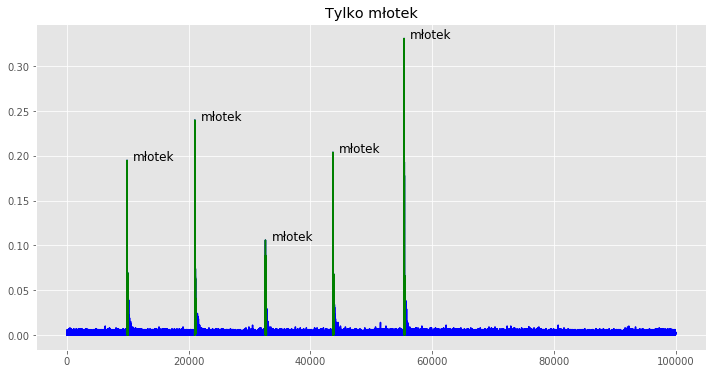

In [10]:
pomiary = ['uderzenia/połączone/uderzenia1/ai0', 'uderzenia/połączone/uderzenia2/ai0']
dane = wczytaj_dane(0.2, foldery=pomiary)
clf = trenuj_svm(dane)
ax1 = testuj_pomiar(directory = 'zmienne pochylenie/obc_uderzenia/2_ai0.csv', skaluj=False);
ax1.set_title("Tylko klucz");
ax2 = testuj_pomiar(directory = 'zmienne pochylenie/obc_uderzenia2/2_ai0.csv', skaluj=False);
ax2.set_title("Tylko młotek");

Test pomiarów bez obciążenia analogiczny do powyższego

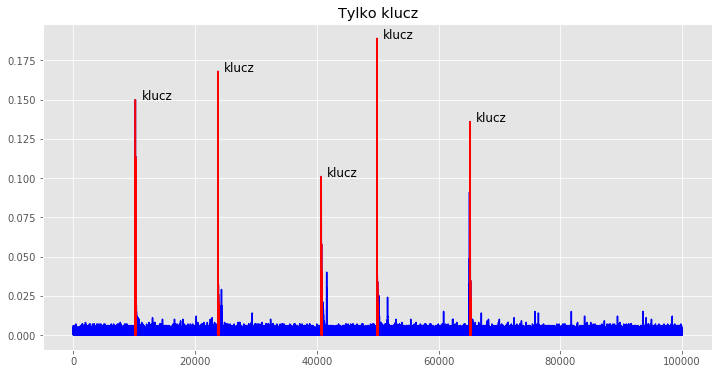

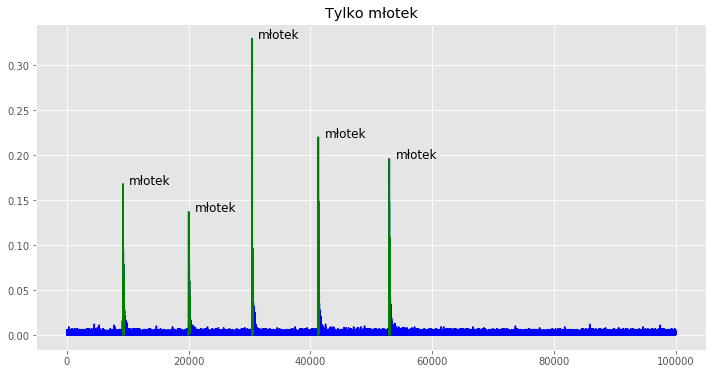

In [11]:
ax1 = testuj_pomiar(directory = 'zmienne pochylenie/bez_obc_uderzenia/2_ai0.csv', skaluj=False);
ax1.set_title("Tylko klucz");
ax2 = testuj_pomiar(directory = 'zmienne pochylenie/bez_obc_uderzenia2/2_ai0.csv', skaluj=False);
ax2.set_title("Tylko młotek");

Połączenie danych nie wpływa widocznie negatywnie na klasyfikacje



-------------------
Dla danych bez podziału wg czujników oraz z i bez obciążeniem

- skalowane

Wczytywanie danych
   Ilość danych klucz:        60
   Ilość danych młotek:       51
   Ilość danych wczytanych:   111
   Ilość danych treningowych: 88
   Ilość danych testowych:    23
Trening modelu
   Klasyfikator: LinearSVC
   Poprawność dla danych testowych:    78.26%
   Poprawność dla danych treningowych: 96.59%


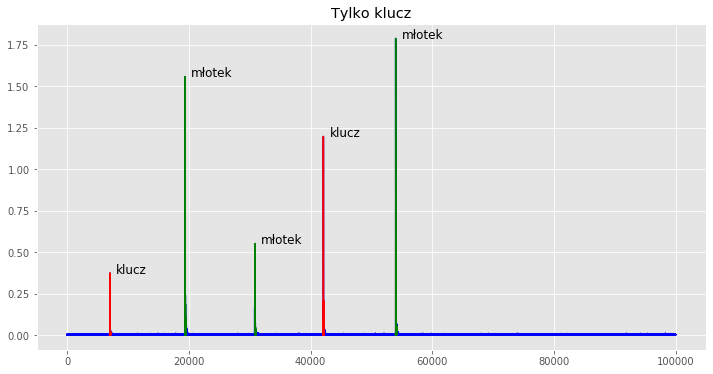

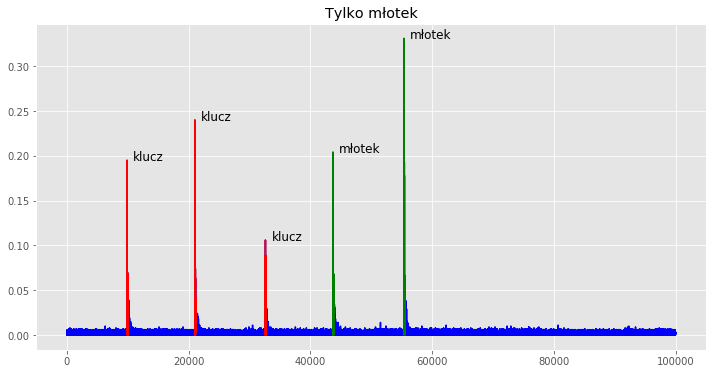

In [12]:
pomiary = ['uderzenia/skalowane/bez_sortowania/uderzenia1', 'uderzenia/skalowane/bez_sortowania/uderzenia2']
dane = wczytaj_dane(0.2, foldery=pomiary)
clf = trenuj_svm(dane)
ax1 = testuj_pomiar(directory = 'zmienne pochylenie/obc_uderzenia/2_ai0.csv', skaluj=True);
ax1.set_title("Tylko klucz");
ax2 = testuj_pomiar(directory = 'zmienne pochylenie/obc_uderzenia2/2_ai0.csv', skaluj=True);
ax2.set_title("Tylko młotek");

- Bez skalowania

Wczytywanie danych
   Ilość danych klucz:        60
   Ilość danych młotek:       51
   Ilość danych wczytanych:   111
   Ilość danych treningowych: 88
   Ilość danych testowych:    23
Trening modelu
   Klasyfikator: NuSVC linear kernel
   Poprawność dla danych testowych:    56.52%
   Poprawność dla danych treningowych: 94.32%


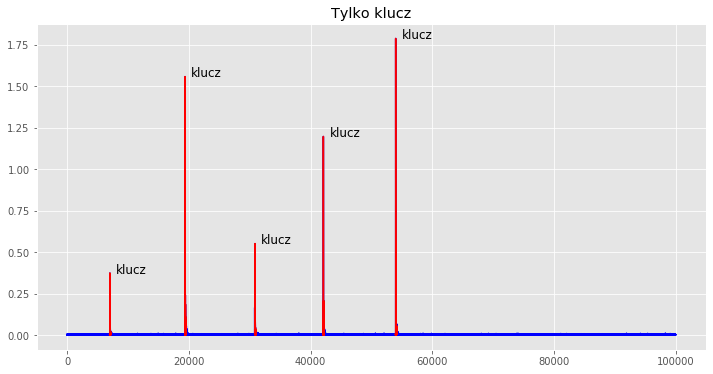

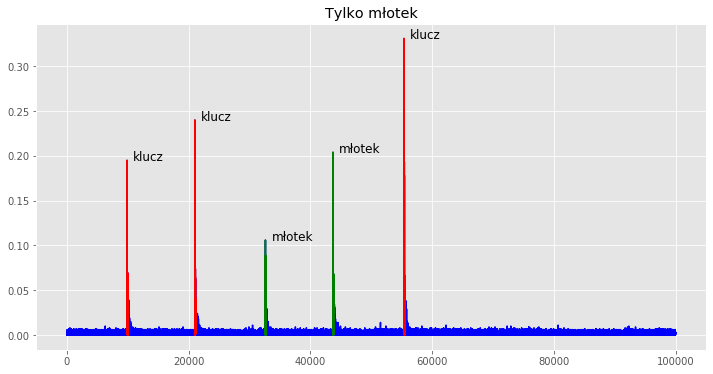

In [13]:
pomiary = ['uderzenia/bez_sortowania/uderzenia1', 'uderzenia/bez_sortowania/uderzenia2']
dane = wczytaj_dane(0.2, foldery=pomiary)
clf = trenuj_svm(dane)
ax1 = testuj_pomiar(directory = 'zmienne pochylenie/obc_uderzenia/2_ai0.csv', skaluj=False);
ax1.set_title("Tylko klucz");
ax2 = testuj_pomiar(directory = 'zmienne pochylenie/obc_uderzenia2/2_ai0.csv', skaluj=False);
ax2.set_title("Tylko młotek");

- Połączenie pomiarów ze wszystkich czujników do jednej klasyfikacji znacznie pogarsza wyniki.
- Skalowanie zdaje się nie mieć wpływu na jakość klasyfikacji